<a href="https://colab.research.google.com/github/carlosEcl06/informaticsMedImages/blob/main/colabGrupo2aval3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RIB0107 - Fundamentos de Informática em Imagens Médicas: Avaliação Parcial 3
## GRUPO 2: Carlos, Gabriel, Guilherme, Kathley, Raul, Victor, Vinícius e Vitor
### Construção e treinamento de um modelo de classificação baseado em rede neural convolucional para a diferenciação de fraturas vertebrais por compressão benignas e malignas

### 1. Importação de bibliotecas

In [1]:
# Se ainda não instalado, descomentar e rodar:
! pip install pynrrd

In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import string
import random
from tensorflow import keras
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Importação da base de dados
Notas:
A base foi organizada pela Informata Biomédica (ex-aluna de nosso curso) Natália Santana Chiari Correia, como parte de sua pesquisa de doutorado no Programa de Pós-Graduação em Clínica Médica da FMRP, sob orientação dos Profs. Paulo e Marcello.

ATENÇÃO: Essa base é para uso exclusivo na disciplina e não pode ser compartilhada ou utilizada para outras finalidades sem autorização específica dos professores ou da sua organizadora.

A base contém:

- Os exames originais em formato DICOM anonimizados.
- Um arquivo .xlsx com a classe de cada paciente, o sexo, a idade e quais corpos vertebrais foram segmentados.
- Outras duas pastas além dos exames originais: uma com as imagens requantizadas para 256 níveis de tons de cinza no formato .nrrd e outra com os arquivos de segmentação no formato .seg.nrrd.

In [4]:
#caminhoCarlos="/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPrático3/dados"
#caminhoGuilherme="/content/Trabalho3/dados"
#caminhokat = "/content/drive/MyDrive/TrabalhoPratico3/dados"
#caminhoFulano="</content/drive/<seu_caminho>"

# Adicione acima o seu caminho para a pasta dados, e antes de executar essa célula copie ele para o comando abaixo
! cp -r '/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPratico3/dados' '/content/'

^C


Favor, verificar se a pasta dados apareceu na barra de arquivos do colab

In [5]:
! unzip '/content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip'
! unzip '/content/dados/Cópia de 2-Rescaled_256_NRRD-20220915T191517Z-001.zip'
! unzip '/content/dados/Cópia de 3-Segmentation_NRRD-20220916T175039Z-001.zip'

Archive:  /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip or
        /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip.zip, and cannot find /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip.ZIP, period.
Archive:  /content/dados/Cópia de 2-Rescaled_256_NRRD-20220915T191517Z-001.zip
replace 2-Rescaled_256_NRRD/P55.nrrd? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/dados/Cópia de 3-Segmentation_NRRD-20220916T175039Z-001.zip
replace 3-Segmentation_NRRD/P61L1.seg.nrrd? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


As imagens da base agora se encontram distribuídas em três pastas presentes no diretório "content" do colab

In [6]:
# Leitura da tabela excel contendo informações dos pacientes
patientsTable = pd.read_excel('/content/dados/Cópia de Patients.xlsx')

### 3. Visualização inicial dos dados

In [7]:
patientsTable.head(5)

,Id,Age at the exam,Gender,Class,Segmented Vertebra
0,P1,67,F,benign,L1
1,P2,61,F,benign,L1/L3/L5
2,P3,65,M,benign,L1
3,P4,84,M,benign,L3
4,P5,78,F,benign,L1/L4


In [8]:
patientsTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  91 non-null     object
 1   Age at the exam     91 non-null     int64 
 2   Gender              91 non-null     object
 3   Class               91 non-null     object
 4   Segmented Vertebra  91 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.7+ KB


O DataFrame patientsTable possui 91 entradas e 5 colunas. As colunas "Id" e "Gender" contêm strings, enquanto as colunas "Age at the exam" e "Class" contêm números inteiros. Todas as colunas não têm valores nulos, o que significa que todas as entradas nas colunas possuem valores.

Para visualização inicial das imagens, foram utilizados os seguintes sites:

[Visualizador de imagens DICOM (extenção .dcm) gratuito na web](https://www.imaios.com/br/imaios-dicom-viewer)

[Conversor de arquivos "near raw" (.nrrd) para .dcm](https://www.onlineconverter.com/nrrd-to-dicom)

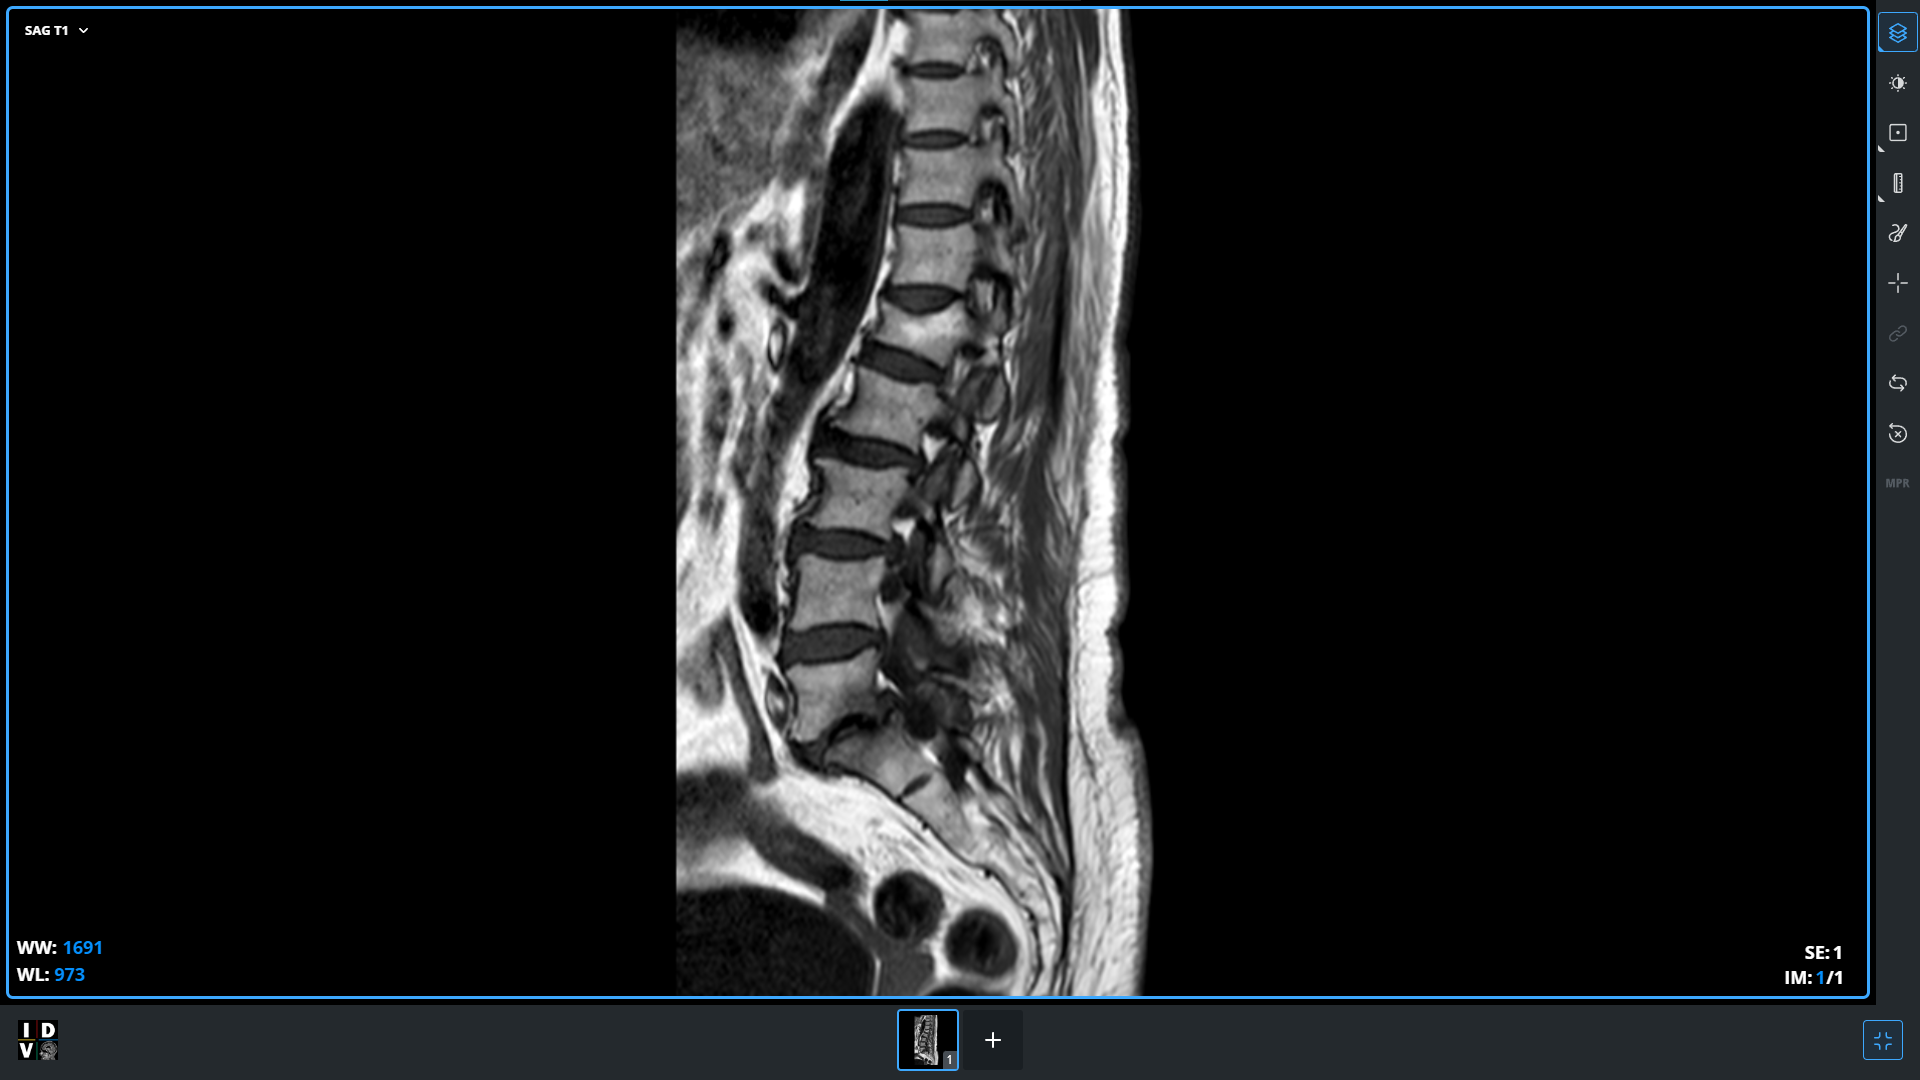
/content/1-Original_Anon_Dicom/P1/I00005.dcm.dcm aberta no visualizador web IMAIOS

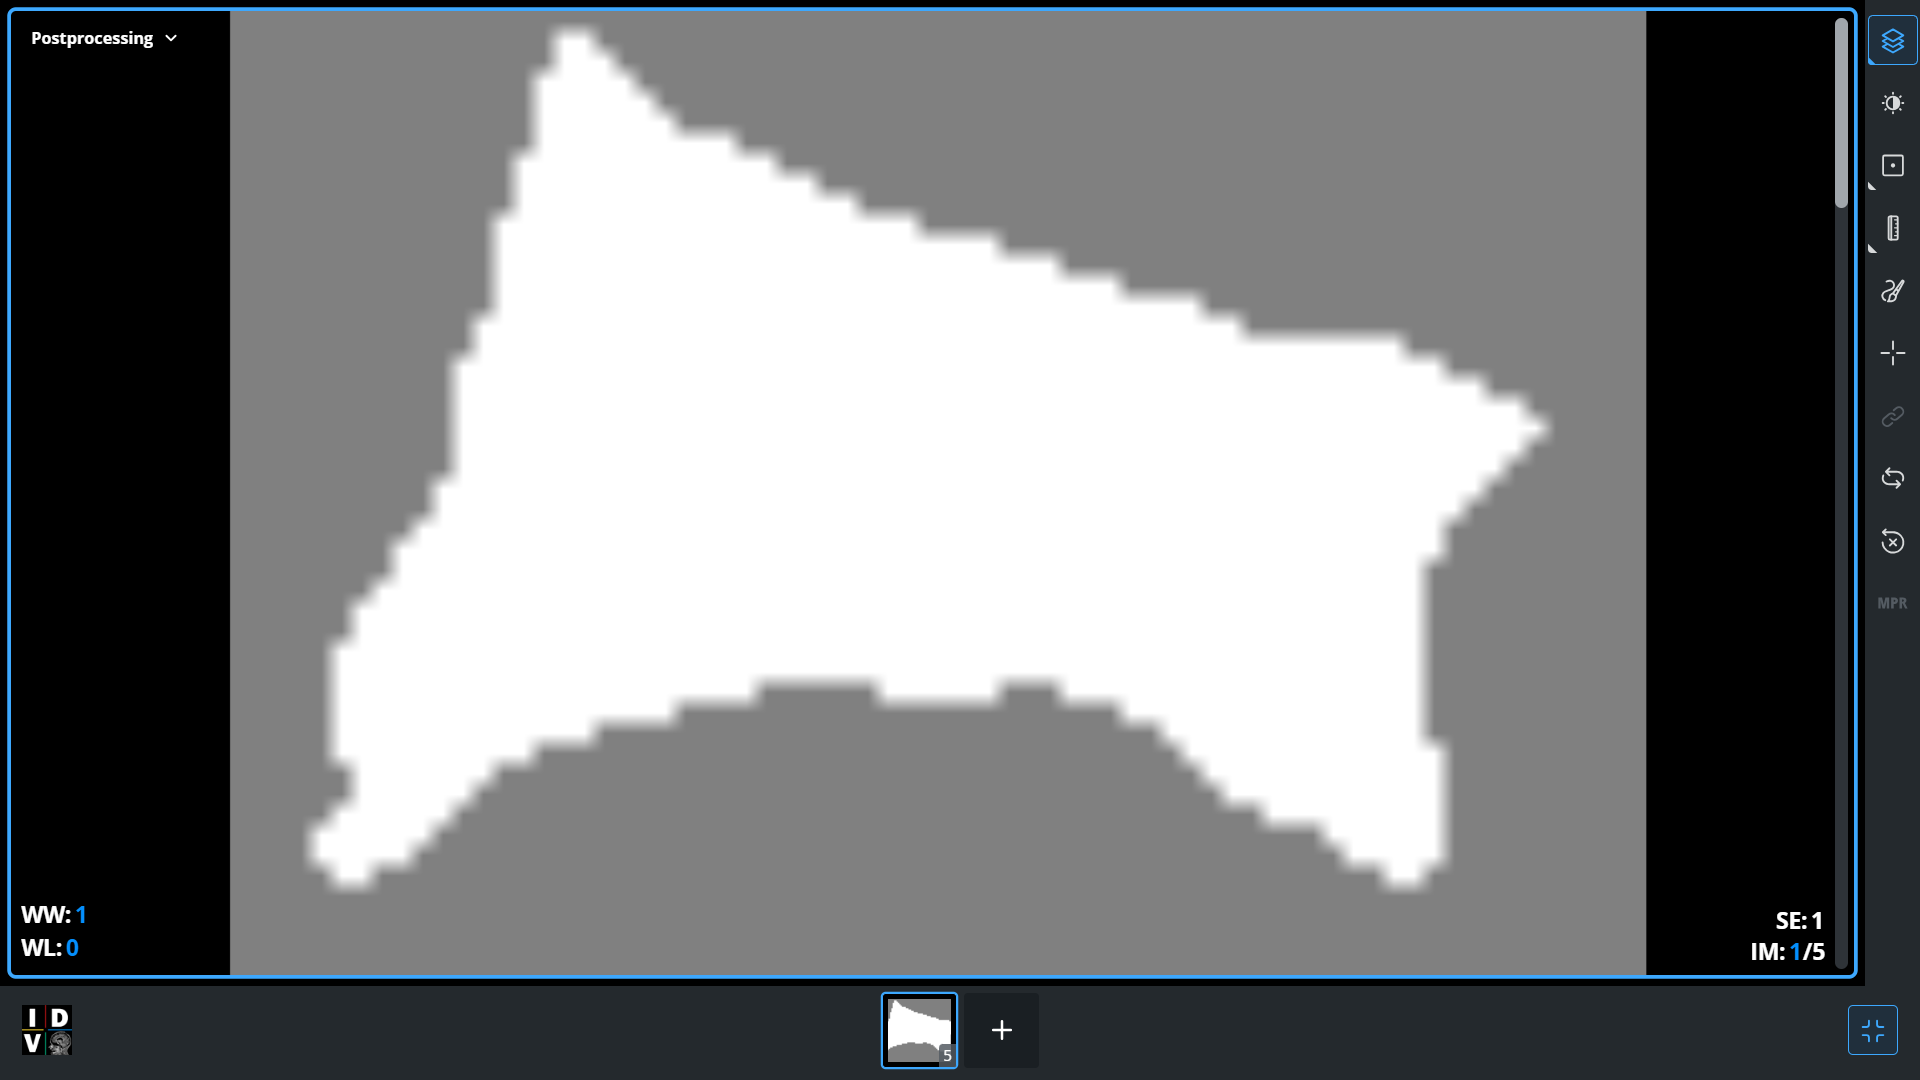
/content/3-Segmentation_NRRD/P1L1.seg.nrrd aberta no visualizador IMAIOS após conversão no Online Converter. É exibida a primeira de 5 fatias

Chaves do dicionário de máscaras: 'P1L1' = Paciente 1: Vértebra L1

Chave do dicionário de imagens: Apenas o paciente. ex: 'P1'

### 4. Pré-pocessamento das imagens. Utilização das máscaras.
#### 4.1 Preparo dos Dicionários

Máscaras

In [9]:
path_mask = '/content/3-Segmentation_NRRD/' # Caminho para as máscaras
os.chdir(path_mask)

In [10]:
masks = {}  # Cria um dicionário vazio chamado "masks"
header_mask = {}  # Cria um dicionário vazio chamado "header_mask"

In [11]:
seg_folder = '3-Segmentation_NRRD' # Nome do diretório contendo as segmentações
seg_sufix = '.seg.nrrd' # Extensão dos arquivos de segmentação

In [12]:
# Loop de leitura das segmentações
for file in os.listdir():
    if file.endswith(seg_sufix):
        file_path = path_mask + file
        # Encontre os índices das substrings 'seg_folder' e 'seg_sufix'
        segFolderIndex = file_path.index(seg_folder)
        segSufixIndex = file_path.index(seg_sufix)
        keyname = file_path[segFolderIndex + len(seg_folder):segSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        masks[keyname], header_mask[keyname] = nrrd.read(file_path)

In [13]:
masks.keys()

dict_keys(['P10L3', 'P90L4', 'P16L1', 'P5L1', 'P35L3', 'P72L1', 'P48L3', 'P46L4', 'P26L3', 'P2L3', 'P69L3', 'P67L3', 'P71L2', 'P18L4', 'P21L2', 'P56L1', 'P3L1', 'P43L4', 'P55L3', 'P26L1', 'P51L5', 'P81L1', 'P62L4', 'P73L4', 'P16L2', 'P34L1', 'P23L2', 'P9L2', 'P37L4', 'P2L5', 'P59L4', 'P45L3', 'P64L2', 'P24L3', 'P27L4', 'P15L2', 'P6L3', 'P10L5', 'P26L2', 'P41L5', 'P39L5', 'P75L1', 'P29L1', 'P35L4', 'P74L2', 'P33L1', 'P13L2', 'P87L5', 'P36L2', 'P35L1', 'P32L4', 'P8L4', 'P45L5', 'P85L1', 'P35L5', 'P42L5', 'P51L2', 'P82L2', 'P24L2', 'P40L4', 'P8L5', 'P38L4', 'P24L5', 'P5L4', 'P10L4', 'P60L2', 'P56L2', 'P28L4', 'P6L1', 'P22L2', 'P42L4', 'P65L1', 'P55L2', 'P61L1', 'P49L5', 'P79L4', 'P70L3', 'P7L1', 'P41L4', 'P32L1', 'P47L3', 'P20L1', 'P42L1', 'P80L5', 'P45L1', 'P2L1', 'P50L5', 'P78L2', 'P91L4', 'P89L5', 'P25L1', 'P77L4', 'P76L5', 'P54L1', 'P84L3', 'P19L1', 'P42L3', 'P17L3', 'P1L1', 'P83L3', 'P30L1', 'P8L3', 'P26L4', 'P86L2', 'P57L1', 'P10L2', 'P6L5', 'P42L2', 'P14L3', 'P31L1', 'P49L1', 'P10L

Segmentation mask key: P83L3


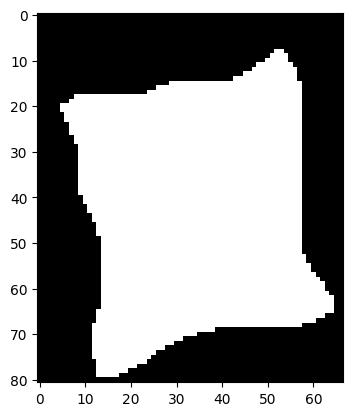

In [14]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(masks.keys()))
plt.imshow(masks[rand_key][:,:,0], cmap='gray')
print('Segmentation mask key:',rand_key)

Imagens originais (versões rescaled)

In [15]:
path_image = '/content/2-Rescaled_256_NRRD/' # Caminho para as imagens
os.chdir(path_image)

In [16]:
images = {}  # Cria um dicionário vazio chamado "images"
header_image = {}  # Cria um dicionário vazio chamado "header_image"

In [17]:
img_folder = '2-Rescaled_256_NRRD' # Nome do diretório contendo as imagens
img_sufix = '.nrrd' # Extensão dos arquivos de imagem

In [18]:
# Loop de leitura das imagens
for file in os.listdir():
    if file.endswith(img_sufix):
        file_path = path_image + file
        # Encontre os índices das substrings 'img_folder' e 'img_sufix'
        imgFolderIndex = file_path.index(img_folder)
        imgSufixIndex = file_path.index(img_sufix)
        keyname = file_path[imgFolderIndex + len(img_folder):imgSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        images[keyname], header_image[keyname] = nrrd.read(file_path)

In [19]:
images.keys()

dict_keys(['P81', 'P63', 'P73', 'P1', 'P76', 'P37', 'P61', 'P90', 'P89', 'P80', 'P62', 'P91', 'P82', 'P23', 'P18', 'P84', 'P52', 'P11', 'P35', 'P58', 'P56', 'P28', 'P22', 'P64', 'P30', 'P25', 'P67', 'P57', 'P70', 'P87', 'P4', 'P59', 'P3', 'P72', 'P31', 'P46', 'P5', 'P24', 'P49', 'P60', 'P47', 'P29', 'P9', 'P41', 'P51', 'P7', 'P69', 'P17', 'P65', 'P27', 'P32', 'P75', 'P6', 'P10', 'P13', 'P16', 'P33', 'P85', 'P39', 'P83', 'P36', 'P79', 'P77', 'P54', 'P42', 'P38', 'P48', 'P14', 'P66', 'P19', 'P34', 'P8', 'P21', 'P50', 'P12', 'P26', 'P74', 'P2', 'P40', 'P78', 'P45', 'P86', 'P55', 'P43', 'P88', 'P68', 'P44', 'P71', 'P53', 'P20', 'P15'])

Original image key: P19


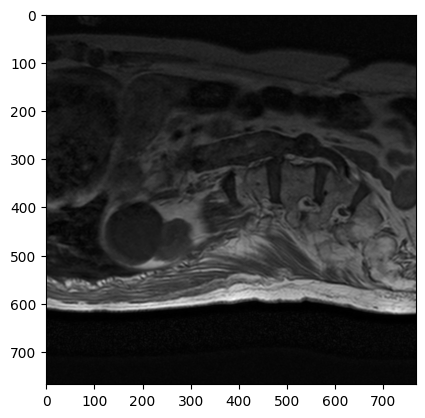

In [20]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(images.keys()))
plt.imshow(images[rand_key][:,:,0], cmap='gray')
print('Original image key:',rand_key)

#### 4.2 Explorando os arquivos

In [168]:
for key in masks:
  print(masks[key][:,:].shape)

(131, 90, 9)
(92, 66, 5)
(81, 64, 4)
(97, 78, 5)
(87, 74, 6)
(88, 66, 4)
(113, 63, 5)
(117, 98, 6)
(127, 86, 7)
(74, 56, 6)
(119, 84, 7)
(91, 55, 8)
(103, 76, 5)
(120, 64, 5)
(91, 69, 6)
(74, 59, 6)
(110, 86, 6)
(114, 95, 7)
(72, 47, 5)
(116, 71, 6)
(97, 79, 7)
(84, 73, 4)
(62, 38, 6)
(105, 81, 5)
(91, 74, 5)
(81, 55, 6)
(86, 63, 5)
(88, 50, 6)
(111, 76, 6)
(72, 71, 6)
(74, 44, 6)
(120, 63, 6)
(81, 54, 5)
(125, 68, 8)
(72, 48, 7)
(115, 102, 5)
(127, 62, 5)
(102, 76, 9)
(123, 86, 6)
(98, 90, 6)
(91, 84, 6)
(76, 44, 6)
(84, 68, 5)
(88, 77, 6)
(104, 76, 6)
(97, 72, 5)
(81, 51, 7)
(111, 69, 6)
(132, 84, 6)
(92, 63, 6)
(84, 61, 7)
(74, 55, 6)
(123, 107, 6)
(75, 64, 5)
(87, 90, 6)
(108, 96, 7)
(115, 85, 6)
(81, 65, 4)
(106, 72, 7)
(89, 53, 7)
(75, 58, 6)
(110, 93, 7)
(108, 93, 8)
(93, 71, 5)
(118, 94, 9)
(113, 91, 8)
(77, 53, 6)
(123, 51, 6)
(112, 65, 5)
(96, 82, 7)
(105, 71, 6)
(78, 49, 5)
(68, 54, 5)
(105, 80, 5)
(77, 69, 7)
(91, 63, 6)
(76, 54, 5)
(102, 69, 5)
(101, 73, 6)
(84, 68, 6)
(12

In [169]:
for key in images:
  print(images[key][:,:].shape)

(640, 640, 14)
(768, 768, 12)
(768, 768, 12)
(640, 640, 14)
(640, 640, 14)
(960, 960, 12)
(864, 864, 12)
(640, 640, 14)
(704, 704, 15)
(640, 640, 12)
(384, 384, 12)
(800, 800, 12)
(704, 704, 14)
(640, 640, 12)
(864, 864, 12)
(640, 640, 14)
(768, 768, 12)
(864, 1650, 12)
(864, 864, 12)
(800, 800, 14)
(640, 640, 12)
(864, 864, 12)
(704, 704, 14)
(640, 640, 14)
(960, 960, 12)
(864, 864, 12)
(704, 704, 14)
(640, 640, 15)
(640, 640, 14)
(768, 768, 12)
(640, 640, 14)
(640, 640, 12)
(896, 896, 12)
(768, 768, 12)
(640, 640, 14)
(864, 864, 12)
(864, 864, 12)
(864, 864, 14)
(640, 640, 12)
(864, 864, 12)
(896, 896, 12)
(512, 512, 12)
(640, 640, 14)
(864, 864, 12)
(864, 864, 12)
(864, 864, 12)
(640, 1750, 12)
(704, 704, 14)
(640, 640, 14)
(640, 640, 14)
(640, 640, 14)
(640, 640, 12)
(864, 864, 12)
(480, 480, 12)
(640, 640, 14)
(768, 768, 12)
(720, 720, 12)
(576, 576, 14)
(864, 864, 12)
(704, 704, 14)
(960, 960, 12)
(672, 672, 14)
(704, 704, 14)
(640, 640, 12)
(768, 768, 12)
(864, 864, 12)
(1024, 1

In [170]:
# O atributo 'Segmentation_ReferenceImageExtentOffset' informa as coordenadas da máscara em relação à imagem original
header_mask['P1L1']

OrderedDict([('type', 'unsigned char'),
             ('dimension', 3),
             ('space', 'right-anterior-superior'),
             ('sizes', array([70, 48,  5])),
             ('space directions',
              array([[ 0.        , -0.52325583,  0.        ],
                     [-0.02111105,  0.        , -0.52282978],
                     [ 3.99674291, -0.        , -0.1613822 ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('encoding', 'gzip'),
             ('space origin',
              array([  8.12124536,   3.24763441, 181.8327767 ])),
             ('measurement frame',
              array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])),
             ('Segment0_Color', '0.501961 0.682353 0.501961'),
             ('Segment0_ColorAutoGenerated', '1'),
             ('Segment0_Extent', '0 69 0 47 0 4'),
             ('Segment0_ID', 'Segment_1'),
             ('Segment0_Name', 'Segment_1'),
             ('Segment0_Nam

#### 4.3 Seleção da região de interesse das imagens

In [171]:
# Função "zoom"
def submatrix(arr):
    x, y = np.nonzero(arr)
    return arr[x.min():x.max()+1, y.min():y.max()+1]

# Função que "posiciona" a máscara sobre a original de acordo com o header e deixa o resto preto
def segmentarImagem(mask,header,image):

    #mapeia a referência da imagem original de string para int
    refImY,refImX,refImZ = list(map(int, header['Segmentation_ReferenceImageExtentOffset'].split()))

    #pegando o tamanho da máscara
    sizeMaskY, sizeMaskX = mask[:,:,2].shape

    #inicializando matriz segmentos
    segmentos = np.zeros(image.shape[0:2])

    #colocando a máscara dentro da matriz segmentos
    segmentos[refImY:refImY+sizeMaskY,refImX:refImX+sizeMaskX] = segmentos[refImY:refImY+sizeMaskY,refImX:refImX+sizeMaskX] + mask[:,:,0]

    #multiplicando a imagem original pela máscara
    segmentos = segmentos*image[:,:,refImZ+2]

    return submatrix(segmentos)


In [255]:
# Criação de um dicionário vazio
segmentos = {}

In [256]:
for imgkey in list(images.keys()):
  for maskkey in list(masks.keys()):
    if len(maskkey) == 4 and len(imgkey) == 2:
      if maskkey[0:2] == imgkey:
        segmentos[maskkey] = segmentarImagem(masks[maskkey], header_mask[maskkey], images[imgkey])
    if len(maskkey) == 5 and len(imgkey) == 3:
      if maskkey[0:3] == imgkey:
        segmentos[maskkey] = segmentarImagem(masks[maskkey], header_mask[maskkey], images[imgkey])

In [257]:
segmentos

{'P81L1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'P63L4': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'P73L4': array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ..., 218., 200.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 'P1L1': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.      

Segmented image key: P42L5


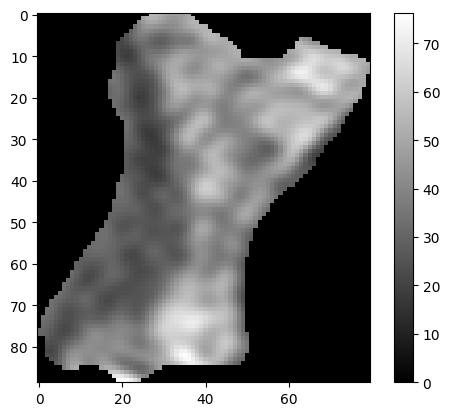

In [258]:
rand_key = random.choice(list(segmentos.keys()))
plt.imshow(segmentos[rand_key],cmap='gray')
plt.colorbar()
print('Segmented image key:',rand_key)

In [259]:
len(segmentos)

130

In [260]:
'''
from PIL import Image
def set_background(img):
    img = Image.fromarray(np.uint16(img))

    background = np.zeros((150, 150))

    d1 = img.size[0]
    d2 = img.size[1]

    PIL_background = Image.fromarray(np.uint16(background))

    pos1 = math.floor((150 - d1) / 2)
    pos2 = math.floor((150 - d2) / 2)

    PIL_background.paste(img, (pos1, pos2))

    PIL_background = np.array(PIL_background)

    PIL_background = PIL_background.astype("uint16")

    PIL_background = np.asarray(PIL_background)

    return PIL_background
'''

'\nfrom PIL import Image\ndef set_background(img):\n    img = Image.fromarray(np.uint16(img))\n    \n    background = np.zeros((150, 150))\n    \n    d1 = img.size[0]\n    d2 = img.size[1]\n\n    PIL_background = Image.fromarray(np.uint16(background))\n    \n    pos1 = math.floor((150 - d1) / 2)\n    pos2 = math.floor((150 - d2) / 2)\n    \n    PIL_background.paste(img, (pos1, pos2))\n    \n    PIL_background = np.array(PIL_background)\n    \n    PIL_background = PIL_background.astype("uint16")\n\n    PIL_background = np.asarray(PIL_background)\n    \n    return PIL_background\n'

In [261]:
'''
for img in list(segmentos.keys()):
  segmentos[img] = set_background(segmentos[img])
'''

'\nfor img in list(segmentos.keys()):\n  segmentos[img] = set_background(segmentos[img])\n'

Segmented image key: P38L4


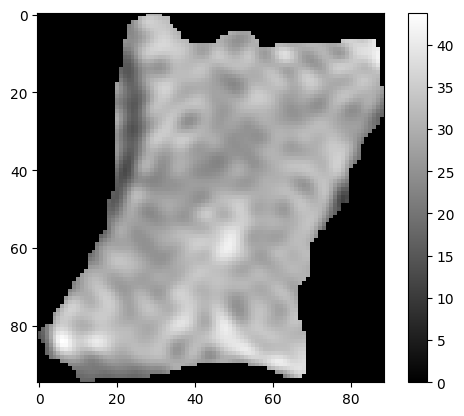

In [262]:
rand_key = random.choice(list(segmentos.keys()))
plt.imshow(segmentos[rand_key],cmap='gray')
plt.colorbar()
print('Segmented image key:',rand_key)

### 5. Tratamento dos dados

In [263]:
dtypes = [('segmento', np.ndarray), ('label', pd.core.series.Series), ('Id', pd.core.series.Series)]

seg_wLabs = np.empty((130), dtype=dtypes)

seg_wLabs

array([(None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, No

In [264]:
i=0
for patient_id in patientsTable['Id']:
  for segkey in list(segmentos.keys()):
    if len(segkey) == 4 and len(patient_id) == 2:
      if segkey[0:2] == patient_id:
        index = patientsTable[patientsTable['Id'] == patient_id].index[0]
        seg_wLabs[i] = segmentos[segkey], patientsTable['Class'][index], patientsTable['Id'][index]
        i+=1
    if len(segkey) == 5 and len(patient_id) == 3:
      if segkey[0:3] == patient_id:
        index = patientsTable[patientsTable['Id'] == patient_id].index[0]
        seg_wLabs[i] = segmentos[segkey], patientsTable['Class'][index], patientsTable['Id'][index]
        i+=1
seg_wLabs

array([(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              ...,
              [10.1618929 , 15.24283935, 31.43835616, ...,  0.        ,
                0.        ,  0.        ],
              [14.60772105, 20.64134496, 36.83686177, ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        , 25.0871731 , 36.20174346, ...,  0.        ,
                0.        ,  0.        ]]), 'benign', 'P1')             ,
       (array([[ 0.        , 28.03382664,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [48.25052854, 38.54651163, 33.42494715, ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        , 49.0591

Estudando a chamada do objeto

In [265]:
seg_wLabs[0]['segmento']

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.1618929 , 15.24283935, 31.43835616, ...,  0.        ,
         0.        ,  0.        ],
       [14.60772105, 20.64134496, 36.83686177, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 25.0871731 , 36.20174346, ...,  0.        ,
         0.        ,  0.        ]])

In [266]:
seg_wLabs[0]['label']

'benign'

In [267]:
seg_wLabs[0]['Id']

'P1'

Criando vetores de dados

In [291]:
X = seg_wLabs[0:129]['segmento']
y = seg_wLabs[0:129]['label']

In [292]:
X

array([array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
               0.        ],
              [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
               0.        ],
              [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
               0.        ],
              ...,
              [0.00487615, 0.00731422, 0.01508558, ..., 0.        , 0.        ,
               0.        ],
              [0.00700946, 0.00990468, 0.01767604, ..., 0.        , 0.        ,
               0.        ],
              [0.        , 0.01203799, 0.01737128, ..., 0.        , 0.        ,
               0.        ]])                                                   ,
       array([[0.        , 0.01183861, 0.        , ..., 0.        , 0.        ,
               0.        ],
              [0.02037607, 0.01627809, 0.01411526, ..., 0.        , 0.        ,
               0.        ],
              [0.        , 0.02071757, 0.01753025, ..., 0.      

In [293]:
y

array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'benign', 'benign', 'malignant', 'malignant',
       'benign', 'benign', 'malignant', 'benign', 'benign', 'benign',
       'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign',
       'benign', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'benign', 'malignant', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'ma

In [294]:
X[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00487615, 0.00731422, 0.01508558, ..., 0.        , 0.        ,
        0.        ],
       [0.00700946, 0.00990468, 0.01767604, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01203799, 0.01737128, ..., 0.        , 0.        ,
        0.        ]])

In [295]:
# "Compactando" imagens para acelerar o treinamento
for index in range(129):
  X[index] = X[index]/np.argmax(X[index])

In [296]:
X[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.33980241e-06, 3.50970362e-06, 7.23876371e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.36346597e-06, 4.75272365e-06, 8.48178374e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.77638720e-06, 8.33554609e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [297]:
from PIL import Image
import numpy as np

# Definir o tamanho desejado
tamanho_desejado = (30, 30)

# Redimensionar imagens
imagens_redimensionadas = []
for img in X:
    img_pil = Image.fromarray(img)
    # Usar Image.LANCZOS para redimensionar
    img_redimensionada = img_pil.resize(tamanho_desejado, Image.LANCZOS)
    imagens_redimensionadas.append(np.array(img_redimensionada))

X = imagens_redimensionadas

# Converter para array do NumPy e normalizar
# imagens_np = np.array(imagens_redimensionadas) / 255.0

# Rótulos já estão em rotulos_np se você seguiu os passos anteriores

# Agora você pode usar imagens_np e rotulos_np para treinar seu modelo no Keras

In [298]:
X = np.asarray(X)

In [299]:
type(X)

numpy.ndarray

In [300]:
X = tf.expand_dims(X, axis=3)
X = np.asarray(X)

In [301]:
y_cat = []
for label in y:
  if label == 'benign':
    y_cat.append(0)
  else:
    y_cat.append(1)

In [302]:
y_cat = np.asarray(y_cat)

In [303]:
# Dividindo base de dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.3)

In [304]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.33)

In [305]:
X_train.shape

(90, 30, 30, 1)

In [306]:
type(X_train)

numpy.ndarray

In [307]:
y_train.shape

(90,)

In [308]:
type(y_train)

numpy.ndarray

In [309]:
X_val.shape

(26, 30, 30, 1)

In [310]:
X_test.shape

(13, 30, 30, 1)

In [331]:
from keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (30, 30, 1)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_15 (Dense)            (None, 128)              

In [332]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [333]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 100,
                    validation_data = (X_val, y_val))

Epoch 1/100
3/3 [==============================] - 2s 209ms/step - loss: 0.6934 - accuracy: 0.4889 - val_loss: 0.6937 - val_accuracy: 0.4231
Epoch 2/100
3/3 [==============================] - 0s 70ms/step - loss: 0.6911 - accuracy: 0.5222 - val_loss: 0.6957 - val_accuracy: 0.4231
Epoch 3/100
3/3 [==============================] - 0s 80ms/step - loss: 0.6913 - accuracy: 0.5000 - val_loss: 0.6970 - val_accuracy: 0.4231
Epoch 4/100
3/3 [==============================] - 0s 67ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6986 - val_accuracy: 0.4231
Epoch 5/100
3/3 [==============================] - 0s 71ms/step - loss: 0.6917 - accuracy: 0.5000 - val_loss: 0.6966 - val_accuracy: 0.4231
Epoch 6/100
3/3 [==============================] - 0s 72ms/step - loss: 0.6889 - accuracy: 0.4667 - val_loss: 0.6935 - val_accuracy: 0.4231
Epoch 7/100
3/3 [==============================] - 0s 76ms/step - loss: 0.6866 - accuracy: 0.5556 - val_loss: 0.6925 - val_accuracy: 0.5769
Epoch 8/100
3/3 [==

In [334]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

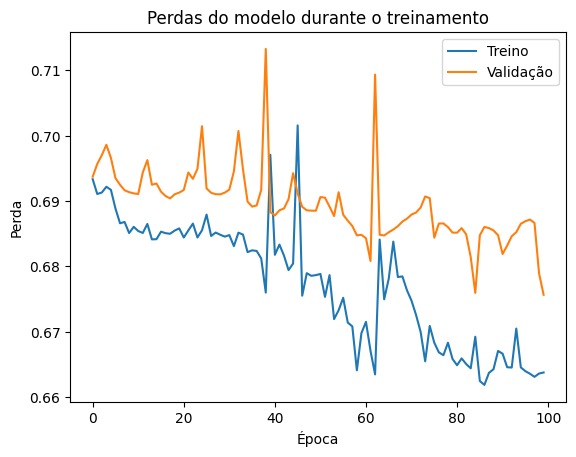

In [335]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdas do modelo durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treino','Validação']);

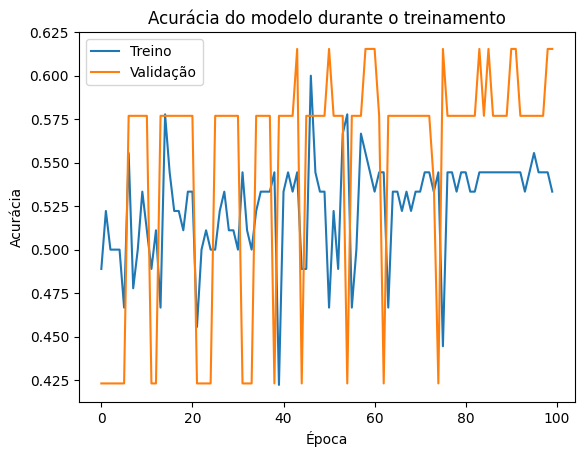

In [336]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treino','Validação']);

In [346]:
# Coletando previsões
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 26ms/step


In [347]:
y_pred

array([[0.52010244, 0.4798976 ],
       [0.52011824, 0.47988185],
       [0.5201114 , 0.4798886 ],
       [0.51989883, 0.48010114],
       [0.52011937, 0.4798807 ],
       [0.52009577, 0.47990417],
       [0.52012   , 0.47987995],
       [0.52012193, 0.4798781 ],
       [0.52012086, 0.4798791 ],
       [0.5201151 , 0.47988495],
       [0.5201189 , 0.4798811 ],
       [0.52010566, 0.47989437],
       [0.520085  , 0.47991496]], dtype=float32)

In [348]:
y_pred = (y_pred > 0.5)

In [350]:
y_pred

array([[ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False]])